# Walkthrough 4: Optical landscapes 
This notebook runs on hardware and uses **1 job** 

## Introduction ##

Barrier objects explored in the last walkthrough are powerful, but there are instances where this abstraction is not flexible enough (e.g., the barrier shapes are pre-determined, etc.).  

In this walkthrough, we explore a more customizable way to alter the potential energy, as a function of position, experienced by the atom ensemble during the manipulation phase. Our new objects consist of `Snapshot`s , aka *snapshots*, which are optical potentials specified by providing a spatially-dependent potential energy at given positions at a fixed time, along with how the provided points should be interpolated.  

Dynamics are described by many snapshots, each with a unique time.  This dynamic construction is called a `Landscape` and is the focus of this walkthrough. 

*NOTE: Landscape-type potentials are sourced from the same laser light as barriers and represent another abstraction available for the user to explore the "painted light" capabilities of Oqtant hardware.*  


This, along with all our example notebooks are publicly available for download from our [GitLab repository.](https://gitlab.com/infleqtion/albert/oqtant-documentation/-/tree/main/oqtant_documentation/docs/examples?ref_type=heads)

### Imports and user authentication ###

In [1]:
from oqtant.schemas.quantum_matter import QuantumMatterFactory

qmf = QuantumMatterFactory()
qmf.get_login()

In [2]:
qmf.get_client()

Job Limits:
╒══════════════╤═══════════════════╤═══════════════╤═══════════════════════╕
│   Daily Used │   Daily Remaining │   Daily Limit │   Purchased Remaining │
╞══════════════╪═══════════════════╪═══════════════╪═══════════════════════╡
│            0 │                10 │            10 │                    10 │
╘══════════════╧═══════════════════╧═══════════════╧═══════════════════════╛


## Snapshot objects  ##

`Snapshot` (*snapshot*) objects represent the desired *instantaneous* optical potential applied to the atom ensemble at a particular time.    

### Object creation ###

Construct a snapshot by passing equal length lists of *positions* (in microns) and corresponding *potentials* (in kHz), the *time* (in ms) at which this snapshot takes place, and an interpolation parameter that communicates how to connect the given data *in space*.

In [3]:
snapshot = qmf.create_snapshot(
    time=2,
    positions=[-10, -9.5, 0, 5, 10],
    potentials=[0, 10, 20, 15, 0],
    interpolation="LINEAR",
)

### Visualizing the instantaneous potential energy contribution ###

Much like for barriers, we can use the `Snapshot.show_potential()` method to visualize the potential energy vs. position associated with a particular snapshot:

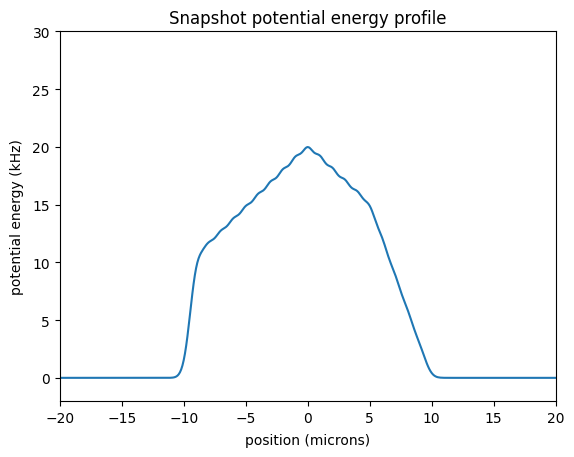

In [4]:
snapshot.show_potential(xlimits=[-20, 20], ylimits=[-2, 30])

Notice the slight "waviness" of the snapshot potential.  This results directly from the snapshot potential being generated as a sum of finite-width, but variable amplitude, projected Gaussian spots, as described in detail in walkthrough 3.  

Compare the actual projected potential (above) with the ideal one represented by the Snapshot object data:

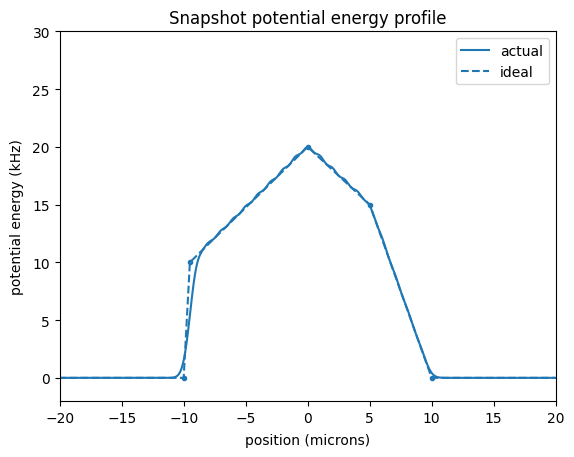

In [5]:
snapshot.show_potential(include_ideal=True, xlimits=[-20, 20], ylimits=[-2, 30])

The input data for the snapshot is shown as points, while the ideal potential based on this data appears as a dashed line.  The solid line, which is the same as above, represents the actual potential applied at the time corresponding to this snapshot, within the limitations of the projection system.  As with barriers, we can see that the biggest differences arise at sharp features where the potential energy changes very quickly as a function of position.  

### Spatial interpolation options ###

The *interpolation* parameter passed to the constructor of our snapshot object controls how the given points formed by the equal length lists of (positions, potentials) are connected *spatially* (as opposed to the previously encountered rf evaporation and barrier interpolation inputs, which controlled how points were connected *in time*.)  Options for spatial interpolation include those options familiar to scipy users and are summarized in the following table:

| Interpolation parameter value           | notes                                |
|-----------------------------------------|--------------------------------------|
| "ZERO"                                  | Spline interpolation at zeroth order |
| "SLINEAR"                               | Spline interpolation at first order  |
| "QUADRATIC"                             | Spline interpolation at second order |
| "CUBIC" or "SMOOTH"                     | Spline interpolation at third order  |
| "OFF" or "STEP" or "PREVIOUS"           | Assumes value of previous data point |
| "NEXT"                                  | Assumes value of next data point     |
| "LINEAR"                                | Linear interpolation between points  |

*Note: The total optical potential applied to the quantum matter sample is bounded below by 0 kHz (no painted light at that position) and above by 100 kHz, which under certain circumstances can alter the expected potential energy landscape.  This is particularly true for high-order interpolation options, e.g. cubic, which tend to overshoot or undershoot these bounds for points close in proximity to them.  Also, just as for multiple barriers that overlap, the presence of snapshots/landscapes and barriers together can lead to optical potentials that sample this energetic ceiling.*       

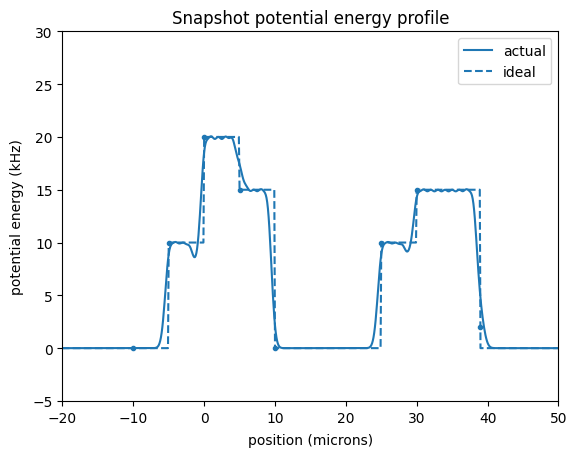

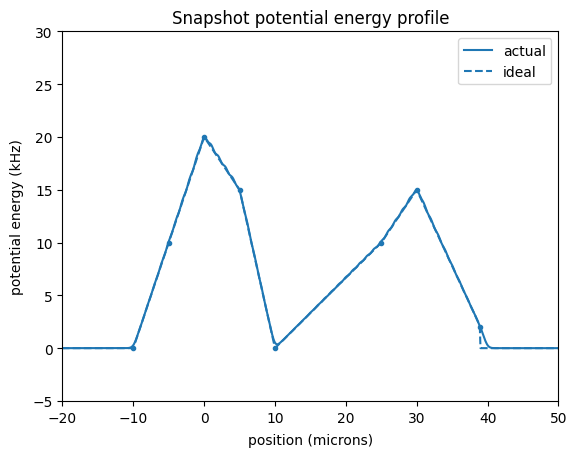

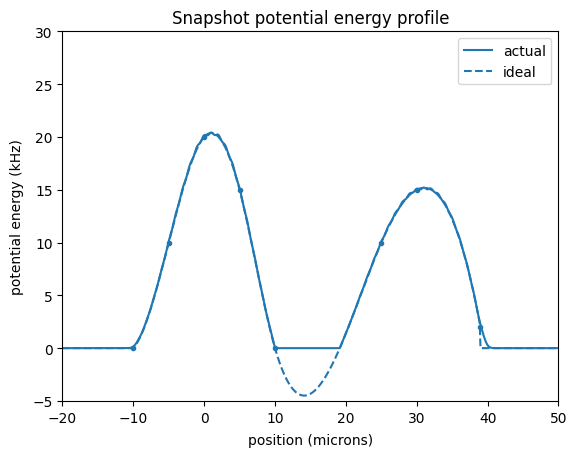

In [6]:
options = ["OFF", "LINEAR", "CUBIC"]
for option in options:
    snapshot = qmf.create_snapshot(
        time=2,
        positions=[-10, -5, 0, 5, 10, 25, 30, 39],
        potentials=[0, 10, 20, 15, 0, 10, 15, 2],
        interpolation=option,
    )
    snapshot.show_potential(ylimits=[-5, 30], xlimits=[-20, 50], include_ideal=True)

The snapshot data structure allows for very flexible potential-energy profiles.

## Landscape objects ##

`Landscape` (*landscape*) objects represent the dynamic potential energy as a function of position. A *landscape* connects a series of snapshots together in time.  A valid *landscape* needs at least two snapshots to define the potential at the start and end time that the landscape should be applied.  At intermediate times between the provided snapshots, the overall landscape / potential energy as a function of position is *linearly* interpolated point-by-point (in position) along the same 1-micron-pitch grid used for projecting individual spots whose sum makes up the optical potential.  This interpolation behavior is not user configurable.  

NOTE: The time values of individual snapshots that make up the overall Landscape object must be at least 1 ms apart.

Let us demonstrate the instantiation of an landscape that evolves between a narrow/short barrier-like object to a wider/taller one with a different spatial interpolation style.  

In [7]:
snapshot1 = qmf.create_snapshot(
    time=2,
    positions=[-10, -5, 0, 5, 10],
    potentials=[0, 10, 20, 15, 0],
    interpolation="LINEAR",
)

snapshot2 = qmf.create_snapshot(
    time=5,
    positions=[-20, -10, 0, 10, 20],
    potentials=[0, 15, 40, 10, 0],
    interpolation="CUBIC",
)

landscape = qmf.create_landscape(snapshots=[snapshot2, snapshot1])

Observe this applied potential energy derived from our *landscape* object at any particular time using the `Landscape.show_potential()` method:

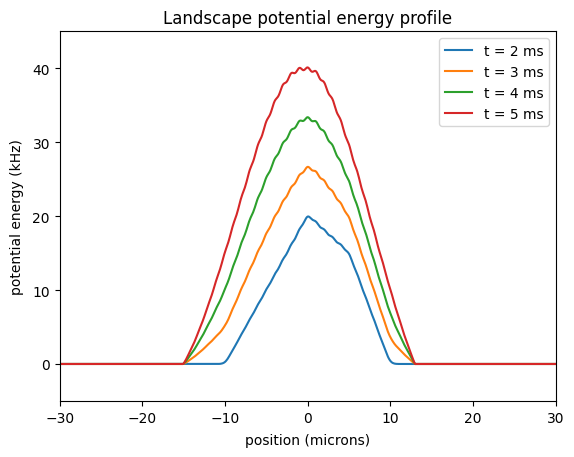

In [8]:
landscape.show_potential(times=[2, 3, 4, 5], xlimits=[-30, 30], ylimits=[-5, 45])

## Add a Landscape object to QuantumMatter ##

Similar to how we added *barrier*s, we can also add *landscape*s to our *matter* objects, in this case by providing a `landscape` parameter during instantiation.  

In this example, we include both a simple Barrier as well as a Landscape object, in this case made up of just two snapshots.  As usual, all objects are created with the help of our *factory*:

In [9]:
# define a simple barrier, just as an example, that lives until t = 10
barrier = qmf.create_barrier(
    positions=[30, 30], heights=[30, 30], widths=[3, 3], shape="GAUSSIAN", times=[3, 10]
)
barrier.evolve(duration=3, height=15, position=-30)

# and the dynamic landscape, consisting of two snapshots for this example
snapshot1 = qmf.create_snapshot(
    time=0,
    positions=[-10, -5, 0, 5, 10],
    potentials=[0, 10, 20, 15, 0],
    interpolation="LINEAR",
)
snapshot2 = qmf.create_snapshot(
    time=15,
    positions=[-20, -10, 0, 10, 20],
    potentials=[0, 15, 40, 10, 0],
    interpolation="LINEAR",
)
landscape = qmf.create_landscape(snapshots=[snapshot1, snapshot2])

# and construct the program
matter = qmf.create_quantum_matter(
    name="paint 1d job trial",
    temperature=100,
    lifetime=20,
    time_of_flight=10,
    barriers=[barrier],
    landscape=landscape,
)

### Visualize the overall potential energy ###

Show the total spatial potential energy as a function of position for various manipulation phase times using the `QuantumMatter.show_potential()` method.  The total potential will include contributions from both our *matter* object's constituent barriers, the new landscape, as well as the background magnetic trapping field: 

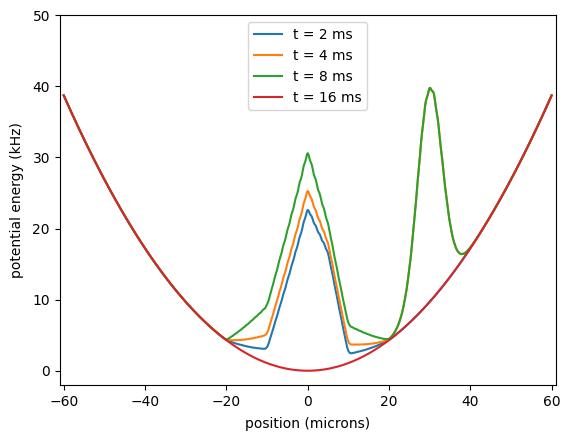

In [10]:
matter.show_potential(times=[2, 4, 8, 16], ylimits=[-2, 50])

As shown, the total potential includes both the evolving landscape as well as the scanning barrier (in addition to the magnetic trapping potential).

### Submit QuantumMatter to Oqtant QMS ###

In [11]:
matter.submit(track=True)

Submitting 1 job(s):

- Job: paint 1d job trial
  Job ID: 2e25bd96-5b85-45a4-b587-cfba8679fcc1


### Retrieve results ###

We retrieve the results in the normal way:

In [13]:
matter.get_result()
matter.status

'COMPLETE'

The output data includes some of the results seen previously for jobs that use time-of-flight imaging.  Due to the presence of the painted potentials, the Oqtant platform will not attempt to fit a temperature to the falling cloud.  This is due to the high chance of interference or structure in this image. Oqtant will return 0 for these calculated fields. Advanced analysis is left to the user.  

In [14]:
matter.output.fields

- mot_fluorescence_image
  - pixels
  - rows
  - columns
  - pixcal
- tof_image
  - pixels
  - rows
  - columns
  - pixcal
- tof_fit_image
  - pixels
  - rows
  - columns
  - pixcal
- tof_fit
  - gaussian_od
  - gaussian_sigma_x
  - gaussian_sigma_y
  - tf_od
  - tf_x
  - tf_y
  - x_0
  - y_0
  - offset
- tof_x_slice
  - points
- tof_y_slice
  - points
- total_mot_atom_number
- tof_atom_number
- thermal_atom_number
- condensed_atom_number
- temperature_nk


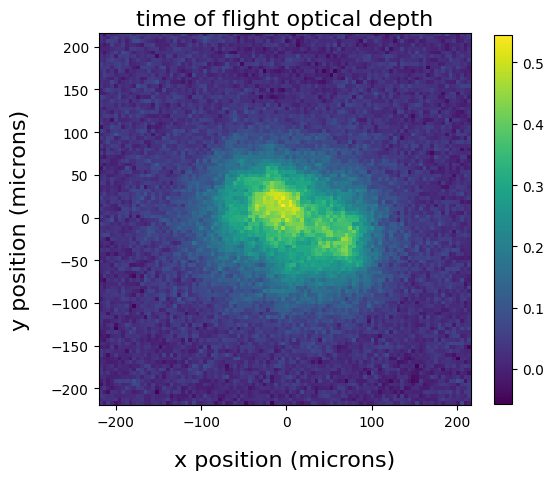

In [15]:
matter.output.plot_tof(figsize=(6, 6))

## Advanced options and discussion ##

### Mapped job type ###

Our *matter* object that includes a *landscape* is mapped to a *PAINT_1D* job type. 

In [16]:
matter.job_type

<JobType.PAINT_1D: 'PAINT_1D'>